## Post-stack inversion with PyLops

### Author: M.Ravasi

Estimating subsurface properties from band-limited seismic data represents an
important task for geophysical subsurface characterization.

In this tutorial, the :py:class:`pylops.avo.poststack.PoststackLinearModelling`
operator is used for modelling of both 1d and 2d synthetic post-stack seismic
data from a profile or 2d model of the subsurface acoustic impedence.

\begin{align}d(t, \theta=0) = w(t) * \frac{d\ln(AI(t))}{dt}\end{align}

where $AI(t)$ is the acoustic impedance profile and $w(t)$ is
the time domain seismic wavelet. In compact form:

\begin{align}\mathbf{d}= \mathbf{W} \mathbf{D} \mathbf{AI}\end{align}

where $\mathbf{W}$ is a convolution operator, $\mathbf{D}$ is a
first derivative operator, and $\mathbf{AI}$ is the input model.
Subsequently the acoustic impedance model is estimated via the
:py:class:`pylops.avo.poststack.PoststackInversion` module. A two-steps
inversion strategy is finally presented to deal with the case of noisy data.




In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import filtfilt

import pylops
from pylops.utils.wavelets import ricker

plt.close('all')
np.random.seed(10)

Let's start with a 1d example. A synthetic profile of acoustic impedance
is created and data is modelled using both the dense and linear operator
version of :py:class:`pylops.avo.poststack.PoststackLinearModelling`
operator.



In [2]:
# model
nt0 = 301
dt0 = 0.004
t0 = np.arange(nt0)*dt0
vp = 1200 + np.arange(nt0) + \
     filtfilt(np.ones(5)/5., 1, np.random.normal(0, 80, nt0))
rho = 1000 + vp + \
      filtfilt(np.ones(5)/5., 1, np.random.normal(0, 30, nt0))
vp[131:] += 500
rho[131:] += 100
m = np.log(vp*rho)

# smooth model
nsmooth = 100
mback = filtfilt(np.ones(nsmooth)/float(nsmooth), 1, m)

# wavelet
ntwav = 41
wav, twav, wavc = ricker(t0[:ntwav//2+1], 20)

# dense operator
PPop_dense = \
    pylops.avo.poststack.PoststackLinearModelling(wav, nt0=nt0, explicit=True)

# lop operator
PPop = pylops.avo.poststack.PoststackLinearModelling(wav, nt0=nt0)

# data
d_dense = PPop_dense*m.flatten()
d = PPop*m

# add noise
dn_dense = d_dense + np.random.normal(0, 2e-2, d_dense.shape)

We can now estimate the acoustic profile from band-limited data using either
the dense operator or linear operator.



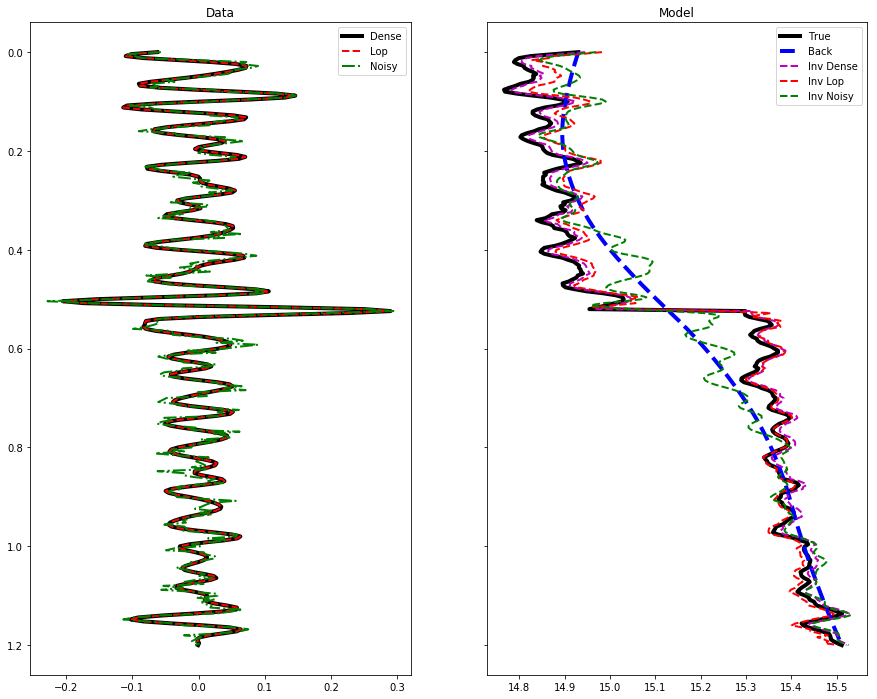

In [3]:
# solve dense
minv_dense = \
    pylops.avo.poststack.PoststackInversion(d, wav, m0=mback, explicit=True,
                                            simultaneous=False)[0]

# solve lop
minv = \
    pylops.avo.poststack.PoststackInversion(d_dense, wav, m0=mback,
                                            explicit=False,
                                            simultaneous=False,
                                            **dict(iter_lim=2000))[0]

# solve noisy
mn = \
    pylops.avo.poststack.PoststackInversion(dn_dense, wav, m0=mback,
                                            explicit=True,
                                            epsR=1e0, **dict(damp=1e-1))[0]

fig, axs = plt.subplots(1, 2, figsize=(15, 12), sharey=True)
axs[0].plot(d_dense, t0, 'k', lw=4, label='Dense')
axs[0].plot(d, t0, '--r', lw=2, label='Lop')
axs[0].plot(dn_dense, t0, '-.g', lw=2, label='Noisy')
axs[0].set_title('Data')
axs[0].invert_yaxis()
axs[0].axis('tight')
axs[0].legend(loc=1)
axs[1].plot(m, t0, 'k', lw=4, label='True')
axs[1].plot(mback, t0, '--b', lw=4, label='Back')
axs[1].plot(minv_dense, t0, '--m', lw=2, label='Inv Dense')
axs[1].plot(minv, t0, '--r', lw=2, label='Inv Lop')
axs[1].plot(mn, t0, '--g', lw=2, label='Inv Noisy')
axs[1].set_title('Model')
axs[1].axis('tight')
axs[1].legend(loc=1)

We see how inverting a dense matrix is in this case faster than solving
for the linear operator (a good estimate of the model is in fact obtained
only after 2000 iterations of lsqr). Nevertheless, having a linear operator
is useful when we deal with larger dimensions (2d or 3d) and we want to
couple our modelling operator with different types of spatial regularizations
or preconditioning.

We move now to a 2d example. First of all the model is loaded and
data generated.



In [4]:
# model
inputfile = '../../../pylops/testdata/avo/poststack_model.npz' # choose file in testdata folder of repo


model = np.load(inputfile)
m = np.log(model['model'][:, ::3])
x, z = model['x'][::3]/1000., model['z']/1000.
nx, nz = len(x), len(z)

# smooth model
nsmoothz, nsmoothx = 60, 50
mback = filtfilt(np.ones(nsmoothz)/float(nsmoothz), 1, m, axis=0)
mback = filtfilt(np.ones(nsmoothx)/float(nsmoothx), 1, mback, axis=1)

# dense operator
PPop_dense = \
    pylops.avo.poststack.PoststackLinearModelling(wav, nt0=nz,
                                                  spatdims=nx, explicit=True)

# lop operator
PPop = pylops.avo.poststack.PoststackLinearModelling(wav, nt0=nz,
                                                     spatdims=nx)

# data
d = (PPop_dense * m.flatten()).reshape(nz, nx)
n = np.random.normal(0, 1e-1, d.shape)
dn = d + n

Finally we perform 4 different inversions:

* trace-by-trace inversion with explicit solver and dense operator with
  noise-free data

* trace-by-trace inversion with explicit solver and dense operator
  with noisy data

* multi-trace regularized inversion with explicit solver and dense operator
  using the result of trace-by-trace inversion as starting guess

  .. math::
       J = ||\Delta \mathbf{d} - \mathbf{W} \Delta \mathbf{AI}||_2 +
       \epsilon_\nabla ^2 ||\nabla \mathbf{AI}||_2

  where $\Delta \mathbf{d}=\mathbf{d}-\mathbf{W}\mathbf{AI_0}$ is
  the residual data

* multi-trace regularized inversion with iterative solver and linear operator
  using the result of trace-by-trace inversion as starting guess



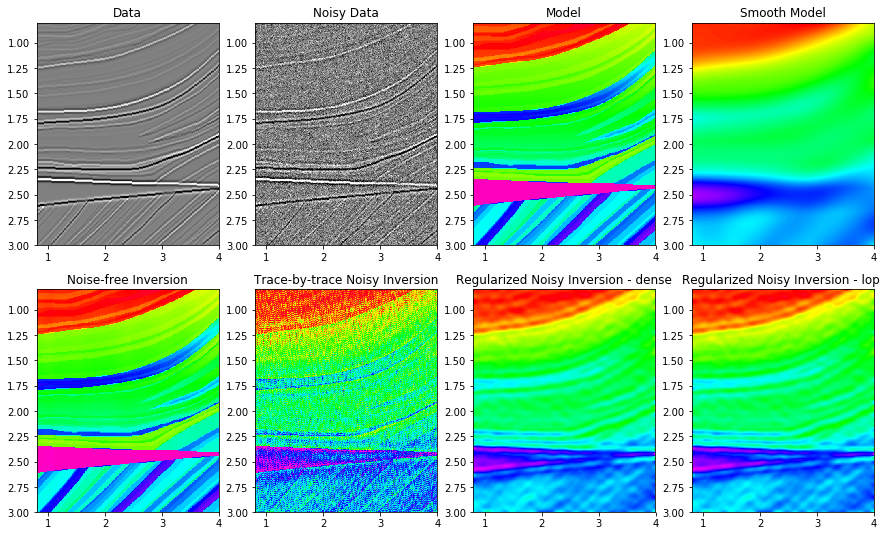

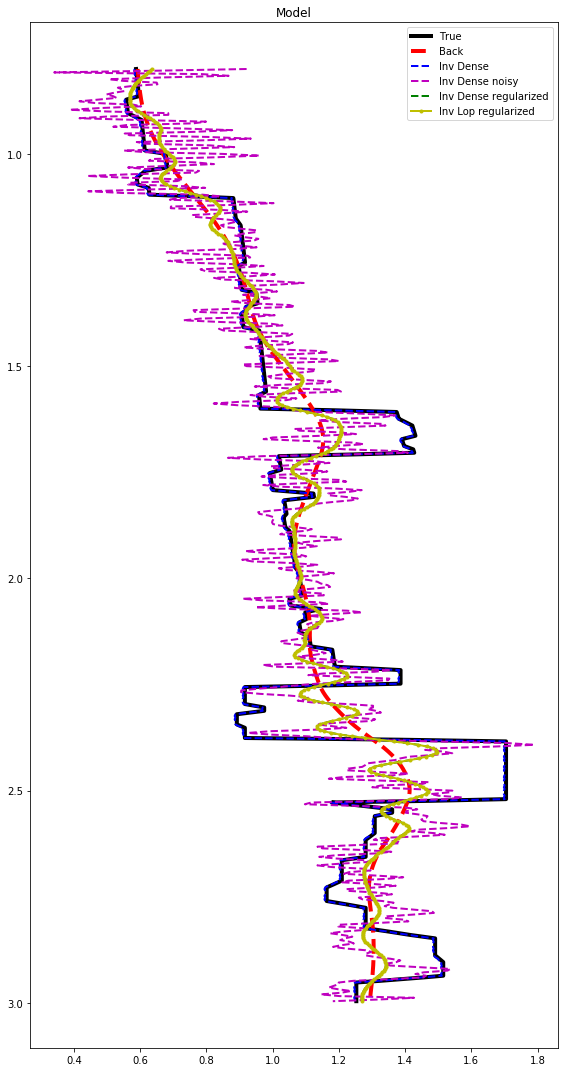

In [5]:
# dense inversion with noise-free data
minv_dense = \
    pylops.avo.poststack.PoststackInversion(d, wav, m0=mback,
                                            explicit=True,
                                            simultaneous=False)[0]

# dense inversion with noisy data
minv_dense_noisy = \
    pylops.avo.poststack.PoststackInversion(dn, wav, m0=mback,
                                            explicit=True, epsI=4e-2,
                                            simultaneous=False)[0]

# spatially regularized dense inversion with noisy data
minv_dense_reg = \
    pylops.avo.poststack.PoststackInversion(dn, wav, m0=minv_dense_noisy,
                                            explicit=True, epsR=5e1,
                                            **dict(damp=np.sqrt(1e-4),
                                                   iter_lim=80))[0]

# spatially regularized lop inversion with noisy data
minv_lop_reg = \
    pylops.avo.poststack.PoststackInversion(dn, wav, m0=minv_dense_noisy,
                                            explicit=False, epsR=5e1,
                                            **dict(damp=np.sqrt(1e-4),
                                                   iter_lim=80))[0]

fig, axs = plt.subplots(2, 4, figsize=(15, 9))
axs[0][0].imshow(d, cmap='gray',
                 extent=(x[0], x[-1], z[-1], z[0]),
                 vmin=-0.4, vmax=0.4)
axs[0][0].set_title('Data')
axs[0][0].axis('tight')
axs[0][1].imshow(dn, cmap='gray',
                 extent=(x[0], x[-1], z[-1], z[0]),
                 vmin=-0.4, vmax=0.4)
axs[0][1].set_title('Noisy Data')
axs[0][1].axis('tight')
axs[0][2].imshow(m, cmap='gist_rainbow',
                 extent=(x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][2].set_title('Model')
axs[0][2].axis('tight')
axs[0][3].imshow(mback, cmap='gist_rainbow',
                 extent=(x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[0][3].set_title('Smooth Model')
axs[0][3].axis('tight')
axs[1][0].imshow(minv_dense, cmap='gist_rainbow',
                 extent=(x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][0].set_title('Noise-free Inversion')
axs[1][0].axis('tight')
axs[1][1].imshow(minv_dense_noisy, cmap='gist_rainbow',
                 extent=(x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][1].set_title('Trace-by-trace Noisy Inversion')
axs[1][1].axis('tight')
axs[1][2].imshow(minv_dense_reg, cmap='gist_rainbow',
                 extent=(x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][2].set_title('Regularized Noisy Inversion - dense')
axs[1][2].axis('tight')
axs[1][3].imshow(minv_lop_reg, cmap='gist_rainbow',
                 extent=(x[0], x[-1], z[-1], z[0]),
                 vmin=m.min(), vmax=m.max())
axs[1][3].set_title('Regularized Noisy Inversion - lop ')
axs[1][3].axis('tight')

fig, ax = plt.subplots(1, 1, figsize=(8, 15))
ax.plot(m[:, nx//2], z, 'k', lw=4, label='True')
ax.plot(mback[:, nx//2], z, '--r', lw=4, label='Back')
ax.plot(minv_dense[:, nx//2], z, '--b', lw=2, label='Inv Dense')
ax.plot(minv_dense_noisy[:, nx//2], z, '--m', lw=2, label='Inv Dense noisy')
ax.plot(minv_dense_reg[:, nx//2], z, '--g', lw=2, label='Inv Dense regularized')
ax.plot(minv_lop_reg[:, nx//2], z, '.-y', lw=2, label='Inv Lop regularized')
ax.set_title('Model')
ax.invert_yaxis()
ax.axis('tight')
ax.legend()
plt.tight_layout()